## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import np_utils

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = tf.keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

### 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型

參數說明：
filepath: 儲存模型的路徑與檔名
mointor: 以什麼指標作為判斷標準
save_best_only: 是否只要儲存最好的

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="C:/Users/rouhui/Documents/GitHub/ML100days/homework/HW86_checkPoint/tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)


In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

pred_final = model.predict(x_test)

# Load back
model = keras.models.load_model("C:/Users/rouhui/Documents/GitHub/ML100days/homework/HW86_checkPoint/tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512   

C:\Users\rouhui\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
49/49 [==============================] - 4s 59ms/step - loss: 2.2255 - accuracy: 0.2654 - val_loss: 2.1016 - val_accuracy: 0.2271
Epoch 2/50
49/49 [==============================] - 3s 53ms/step - loss: 1.7527 - accuracy: 0.3870 - val_loss: 1.9623 - val_accuracy: 0.3094
Epoch 3/50
49/49 [==============================] - 3s 57ms/step - loss: 1.6220 - accuracy: 0.4313 - val_loss: 1.8222 - val_accuracy: 0.3665
Epoch 4/50
49/49 [==============================] - 3s 53ms/step - loss: 1.5431 - accuracy: 0.4590 - val_loss: 1.7335 - val_accuracy: 0.3984
Epoch 5/50
49/49 [==============================] - 3s 69ms/step - loss: 1.4871 - accuracy: 0.4800 - val_loss: 1.6335 - val_accuracy: 0.4309
Epoch 6/50
49/49 [==============================] - 4s 87ms/step - loss: 1.4413 - accuracy: 0.4952 - val_loss: 1.6052 - val_accuracy: 0.4315
Epoch 7/50
49/49 [==============================] - 4s 86ms/step - loss: 1.4004 - accuracy: 0.5108 - val_loss: 1.5602 - val_accuracy: 0.4491
Epoch 8/50
49

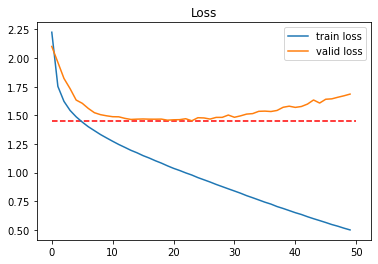

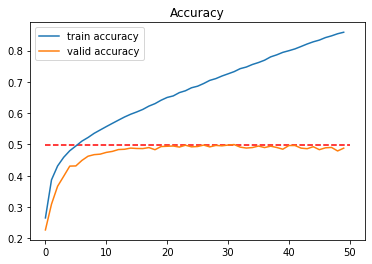

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""


plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

In [10]:
pred_loadback = model.predict(x_test)

from sklearn.metrics import accuracy_score

final_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_final.argmax(axis=-1))
loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_loadback.argmax(axis=-1))

print("Accuracy of final weights: %.3f" % final_model_acc)
print("Accuracy of best weights: %.3f" % loadback_acc)

Accuracy of final weights: 0.488
Accuracy of best weights: 0.498


In [13]:
new_model = build_mlp(input_shape=x_train.shape[1:])
new_model_pred = new_model.predict(x_test)
new_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_acc)

new_model.load_weights("C:/Users/rouhui/Documents/GitHub/ML100days/homework/HW86_checkPoint/tmp.h5")
new_model_pred = new_model.predict(x_test)
new_model_loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_loadback_acc)

Accuracy of best weights: 0.117
Accuracy of best weights: 0.498
